In [77]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

In [40]:
raw_dataset = pd.read_csv('./station_rio.csv', index_col='YEAR')
raw_dataset = raw_dataset.iloc[:,:12]

In [41]:
raw_dataset.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85
1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54
1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53
1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56
1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84


In [42]:
raw_dataset.tail()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
YEAR,,,,,,,,,,,,
2015,29.93,28.43,26.78,25.93,23.18,21.98,22.93,23.53,23.28,25.33,26.43,999.90
2016,27.08,28.98,27.43,27.93,22.93,20.53,21.53,23.23,23.03,24.48,24.78,27.22
2017,28.92,28.27,26.97,25.52,22.57,21.97,20.02,22.42,24.22,25.97,25.47,27.01
2018,28.06,27.21,27.81,26.26,23.81,22.91,22.96,21.91,23.71,24.56,25.61,27.55
2019,30.25,28.05,27.50,26.55,24.85,23.10,21.75,22.30,23.05,25.25,999.90,999.90


In [101]:
def split_dataset(data):
    # split into standard weeks
    train, test = data[:-24], data[-24:]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/12))
    test = np.array(np.split(test, len(test)/12))
    return train, test

def to_supervised(train, n_input, n_out):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [137]:
series = []

#Turning dataset into a serie
for year in range(len(raw_dataset.values)):
    for month in raw_dataset.values[year]:
        series.append(month)

# Handling wrong values
for i in range(len(series)):
    if series[i] > 60:
        num1 = 0
        num2 = 0
        
        k = 0
        while series[k] > 60:
            k = k+1
        num1 = series[k]
        
        k = 0
        while series[k] > 60:
            k = k-1
        num2 = series[k]
        
        series[i] = (num1 + num2)/2


series = np.array(series)
series.shape = (series.shape[0],1)
train, test = split_dataset(series)

n_input=12
train_x, train_y = to_supervised(train, 12, 12)

print(train_x[0].flatten())
print(train_y[0])
print('-------------------------------------------------------------------------')
print(train_x[1].flatten())
print(train_y[1])


[27.73 27.97 25.7  26.49 22.42 22.76 22.14 21.03 21.46 22.46 23.06 25.85]
[26.68 27.16 26.56 23.94 22.76 20.7  21.2  21.81 22.91 22.8  24.51 24.54]
-------------------------------------------------------------------------
[27.97 25.7  26.49 22.42 22.76 22.14 21.03 21.46 22.46 23.06 25.85 26.68]
[27.16 26.56 23.94 22.76 20.7  21.2  21.81 22.91 22.8  24.51 24.54 25.27]


In [194]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 

# define parameters
verbose, epochs, batch_size = 1, 70, 20
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True)))
model.add(Dense(100, activation='relu'))
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.2))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)

Epoch 1/70
21/21 [==============================] - 5s 56ms/step - loss: 153.6377 - val_loss: 13.3938
Epoch 2/70
21/21 [==============================] - 1s 35ms/step - loss: 28.5812 - val_loss: 8.6787
Epoch 3/70
21/21 [==============================] - 1s 37ms/step - loss: 19.2378 - val_loss: 6.3180
Epoch 4/70
21/21 [==============================] - 1s 35ms/step - loss: 15.2390 - val_loss: 6.5207
Epoch 5/70
21/21 [==============================] - 1s 36ms/step - loss: 12.6819 - val_loss: 5.2412
Epoch 6/70
21/21 [==============================] - 1s 36ms/step - loss: 13.2508 - val_loss: 5.1445
Epoch 7/70
21/21 [==============================] - 1s 37ms/step - loss: 13.4725 - val_loss: 6.3902
Epoch 8/70
21/21 [==============================] - 1s 36ms/step - loss: 11.8607 - val_loss: 4.3066
Epoch 9/70
21/21 [==============================] - 1s 36ms/step - loss: 10.7843 - val_loss: 4.0580
Epoch 10/70
21/21 [==============================] - 1s 36ms/step - loss: 10.5587 - val_loss: 5.44

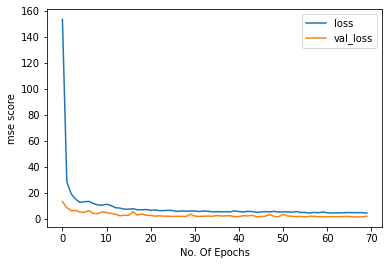

In [195]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")
plt.show()

In [196]:
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

history = [x for x in train]
predictions = list()

for i in range(len(test)):
    yhat_sequence = forecast(model, history, n_input)
    predictions.append(yhat_sequence)
    history.append(test[i, :])

In [199]:
predictions = array(predictions)
y_pred = predictions.flatten()
y_test = test.flatten()

from sklearn.metrics import mean_squared_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse_lstm)

1.6993532546582353


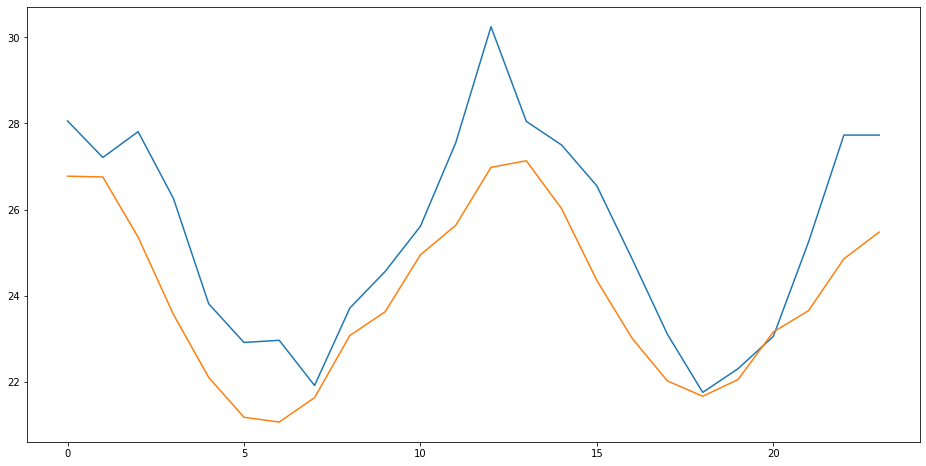

In [200]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='predicted')
plt.show()